**TP 1 – End-to-end Machine Learning project**

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

# Table of Contents
1. [Introduction](#Introduction)
2. [Data Extraction and Loading](#Data-Extraction-and-Loading)
3. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
   - [Inspecting Data](#Inspecting-Data)
   - [Visualizing Distributions](#Visualizing-Distributions)
   - [Geographical Analysis](#Geographical-Analysis)
   - [Correlation Analysis](#Correlation-Analysis)
4. [Data Preparation](#Data-Preparation)
   - [Handling Missing Values](#Handling-Missing-Values)
   - [Encoding Categorical Variables](#Encoding-Categorical-Variables)
   - [Feature Engineering](#Feature-Engineering)
   - [Building Preprocessing Pipelines](#Building-Preprocessing-Pipelines)
5. [Model Selection and Training](#Model-Selection-and-Training)
   - [Linear Regression](#Linear-Regression)
   - [Decision Tree Regressor](#Decision-Tree-Regressor)
   - [Random Forest Regressor](#Random-Forest-Regressor)
   - [Model Evaluation](#Model-Evaluation)
6. [Hyperparameter Tuning](#Hyperparameter-Tuning)
   - [Grid Search](#Grid-Search)
   - [Error Analysis](#Error-Analysis)
7. [Model Testing and Evaluation](#Model-Testing-and-Evaluation)
8. [Model Persistence](#Model-Persistence)
9. [Bonus Exercise](#Bonus-Exercise)


# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.





In [5]:
%pip install sklearn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
# Scikit-Learn ≥0.20 is required
#assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Get the Data

## Download the Data

We start by downloading our dataset

In [9]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [10]:
fetch_housing_data()

In [11]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

## Take a Quick Look at the Data Structure

Now that we have the data, we can load it and have a look at it.

We use the pandas methods and functions to explore our dataset.

In [12]:
housing = load_housing_data()

With the `.head()` method, look at the first rows.

In [12]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Now let's have a look at the data types with the `.info()` method



In [13]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Observation : La colonne total_bedrooms contient des valeurs manquantes
20640 - 20433 = 207

We can have a look at the different values with `.value_counts()`

In [14]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

The ocean_proximity column is a qualitative variable with specific modalities (<1H OCEAN, INLAND, etc.).
Observation : The majority of houses are close to the ocean (<1H OCEAN) or to the inland (INLAND).
Conclusion : This could indicate that geographical location has an important role in changes in home prices.

To have a complete overview of the dataset let's use `.describe()`

In [15]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


As it is not really readable like that, we can plot some histograms :

Saving figure attribute_histogram_plots


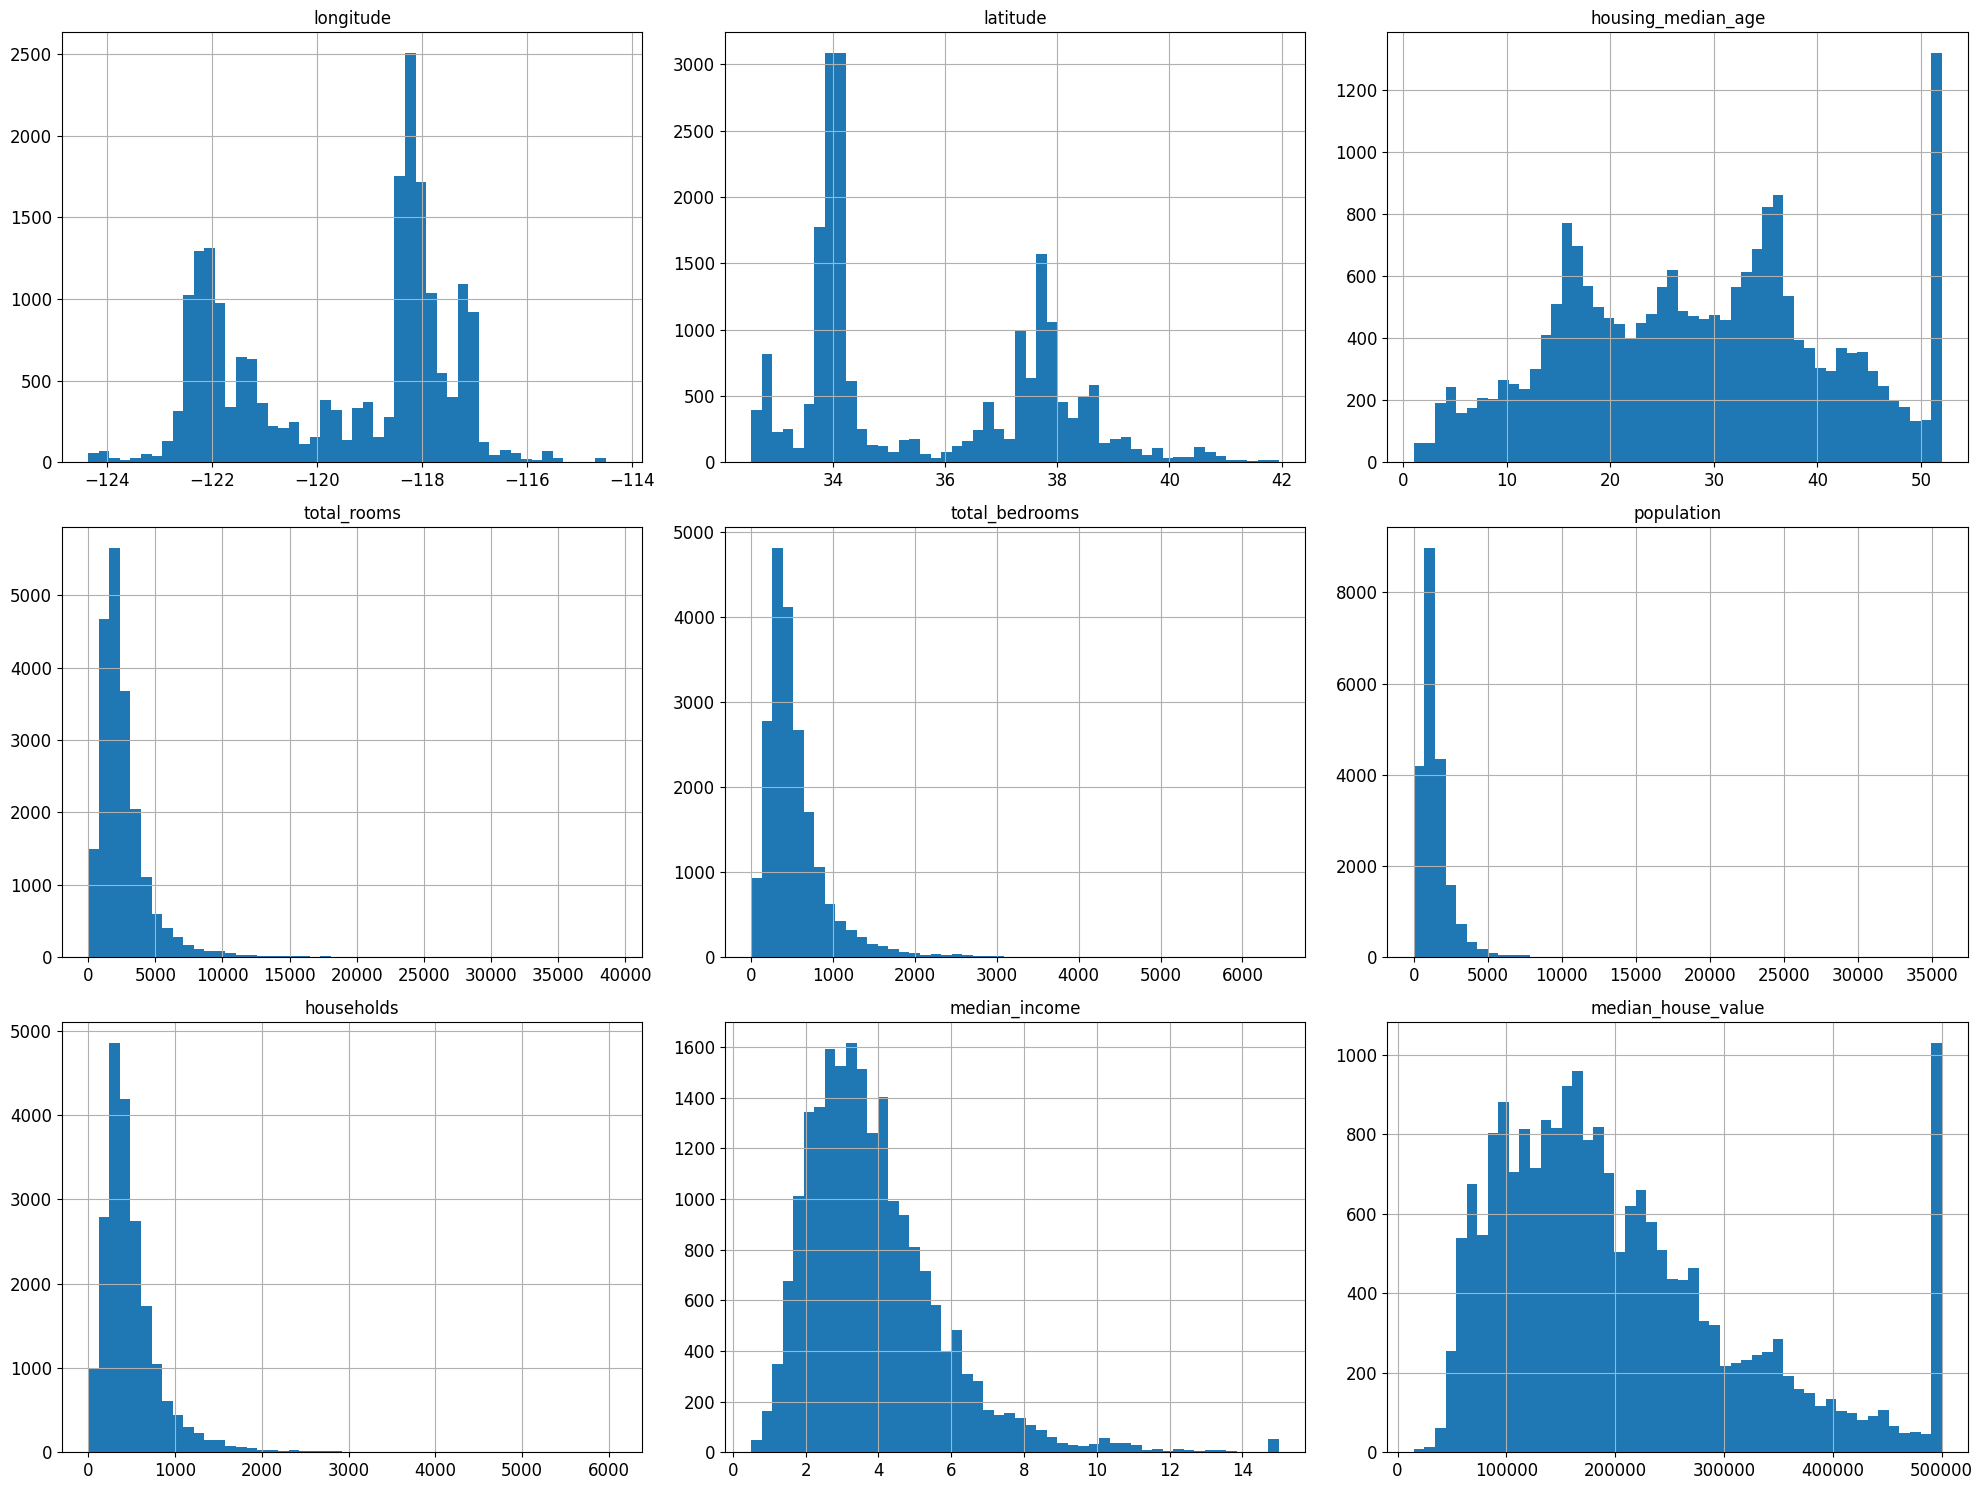

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

### Data Overview conclusion

Conclusion after displaying the distributions :
- The distribution of median_income is highly asymmetric: it may require normalization or transformation to balance its contribution to the model.
- Some variables like total_rooms and total_bedrooms have extreme values, suggesting a need for features engineering (like creating room_per_household ratios).
- median_house_value is capped at 500,000, which can bias the results.

## Create a Test Set

Now that we have a better understanding of the data, we can start working with it.

We start by creating a test set, that we will use to test our model.

As you can imagine, we don't want to write a function every time, so sklearn did it for us with the function `train_test_split`

In [17]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [18]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


We did split the data randomly, but are we sure that the test set still has the same properties and data distribution that the original dataset ?

We can try to use `StratifiedShuffleSplit` from `sklearn.model_selection` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html)) to preserve the `median_income` distribution. 


In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

# Créer une catégorie pour la variable median_income
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

# Configurer StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# Vérifier les distributions
print(housing["income_cat"].value_counts() / len(housing))
print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))


3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64
3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114341
1.0    0.039971
Name: income_cat, dtype: float64


# Discover and Visualize the Data to Gain Insights

To build a robust and performant model, we need to make good use of the data. To do so, we start by gaining some insights.

In [19]:
# To play with the data without harming the training set we make a copy.
housing = train_set.copy()

## Visualizing Geographical Data

We have geographical features : longitude and latitude. It might be useful to plot a scatterplot of all districts to visualize the data.

Saving figure geographic_scatterplot


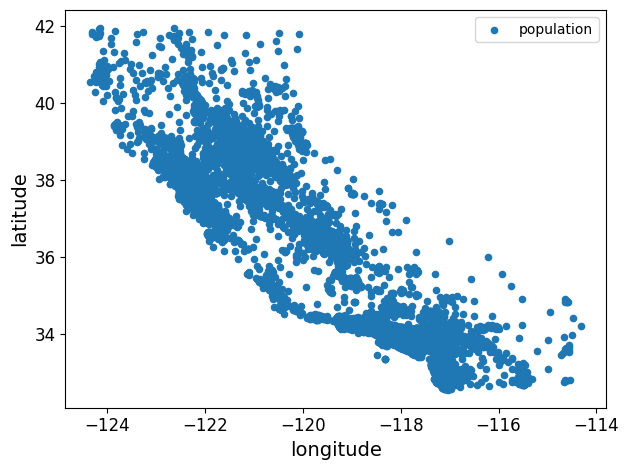

In [15]:
housing.plot(kind="scatter", x="longitude", y="latitude", label='population')
plt.legend()
save_fig("geographic_scatterplot")

This looks like California all right, but other than that it is hard to see any particular pattern. We need to set the `alpha` option to 0.1, it makes it much easier to visualize the places where there is a high density of data points.

Saving figure housing_prices_scatterplot


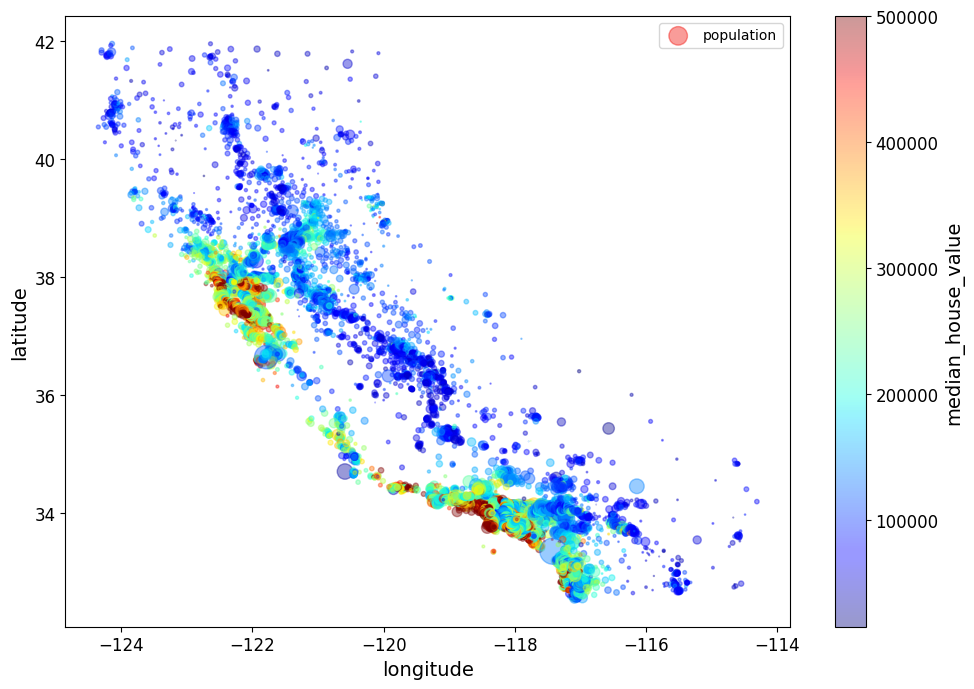

In [17]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

Now that’s much better: you can clearly see the high-density areas, namely the Bay Area and around Los Angeles and San Diego, plus a long line of fairly high density in the Central Valley, in particular around Sacramento and Fresno.

Now let’s look at the housing prices. The radius of each circle represents the district’s population (option s), and the color represents the price (option c). We used a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices):

To make it easier to understand, we can add the californian map as a background.

In [21]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\end_to_end_project\\california.png',
 <http.client.HTTPMessage at 0x294c1fa9330>)

Saving figure california_housing_prices_plot


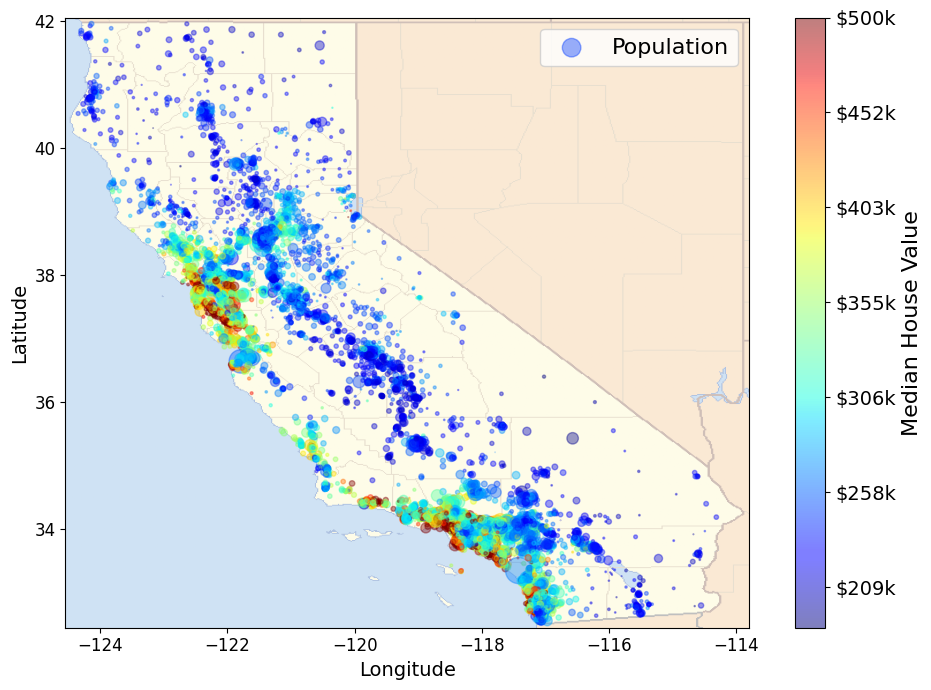

In [22]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

This image tells you that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density (big cities etc)

## Looking for Correlations

Since the dataset is not too large, you can easily compute the standard correlation coefficient (also called Pearson’s r) between every pair of attributes using the `corr()` method

In [19]:
corr_matrix = housing.corr()

In [24]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.690647
total_rooms           0.133989
housing_median_age    0.103706
households            0.063714
total_bedrooms        0.047980
population           -0.026032
longitude            -0.046349
latitude             -0.142983
Name: median_house_value, dtype: float64

The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong positive correlation; for example, the median house value tends to go up when the median income goes up. When the coefficient is close to –1, it means that there is a strong negative correlation; you can see a small negative correlation between the latitude and the median house value (i.e., prices have a slight tendency to
go down when you go north)

Another way to check for correlation between attributes is to use the pandas `scatter_matrix()` function, which plots every numerical attribute against every other numerical attribute.

Saving figure scatter_matrix_plot


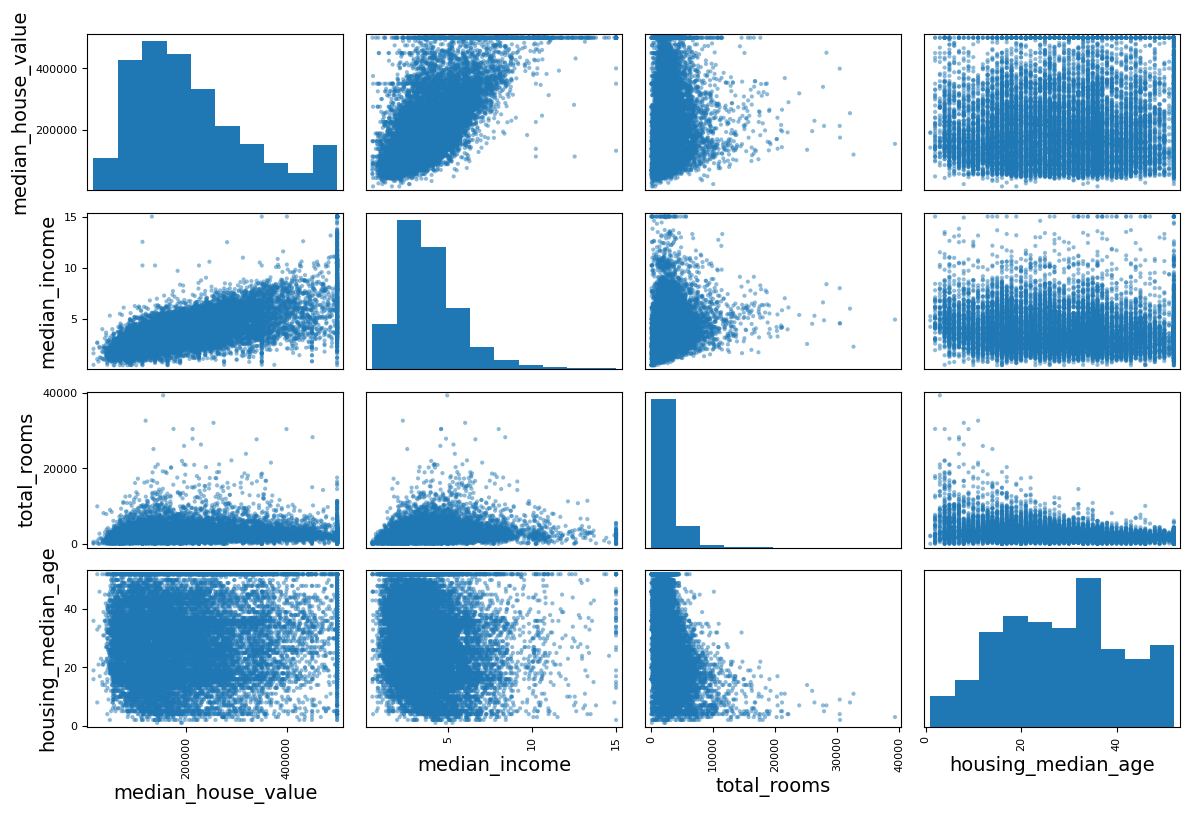

In [25]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

The most promising attribute to predict the median house value is the median income, so let’s zoom in on their correlation scatterplot

Saving figure income_vs_house_value_scatterplot


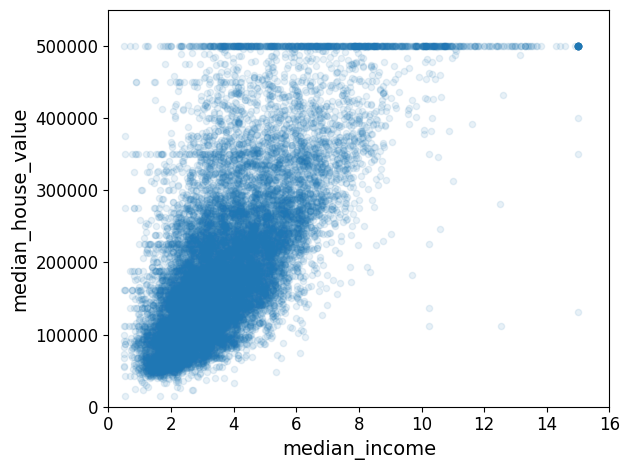

In [26]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

## Experimenting with Attribute Combinations

Hopefully the previous sections gave you an idea of a few ways you can explore the data and gain insights. You identified a few data quirks that you may want to **clean** up before feeding the data to a Machine Learning algorithm, and you found interesting **correlations** between attributes, in particular with the target attribute. You also noticed that some attributes have a tail-heavy distribution, so you may want to transform them (e.g., by computing their logarithm).

One last thing you may want to do before preparing the data for Machine Learning algorithms is to **try out various attribute combinations**. For example, the total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at. Let’s create these new attributes:

In [27]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

And now let’s look at the correlation matrix again:

In [20]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
income_cat            0.643892
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

**Question** : What can you say about those new features ?

In [29]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.582290,35.643149,28.608285,2642.004784,538.496851,1426.453004,499.986919,3.880754,207194.693738,5.435235,0.212858,3.096961
std,2.005654,2.136665,12.602499,2174.646744,419.007096,1137.056380,380.967964,1.904294,115622.626448,2.387375,0.057995,11.578744
min,-124.350000,32.550000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.888889,0.100000,0.692308
25%,-121.810000,33.930000,18.000000,1454.000000,296.750000,789.000000,280.000000,2.566700,119800.000000,4.452055,0.175178,2.428799
50%,-118.510000,34.260000,29.000000,2129.000000,437.000000,1167.000000,410.000000,3.545800,179850.000000,5.235874,0.202808,2.817240
75%,-118.010000,37.720000,37.000000,3160.000000,647.000000,1726.000000,606.000000,4.773175,265125.000000,6.061037,0.239501,3.280000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# Prepare the Data for Machine Learning Algorithms

It’s time to prepare the data for your Machine Learning algorithms !

In [30]:
# First let’s revert to a clean training set
housing = train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = train_set["median_house_value"].copy()

## Data Cleaning

Most Machine Learning algorithms cannot work with missing features, so let’s create a few functions to take care of them. We saw earlier that the total_bedrooms attribute has some missing values, so let’s fix this.

3 options are possible:

```python
housing.dropna(subset=["total_bedrooms"])    # option 1
housing.drop("total_bedrooms", axis=1)       # option 2
median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)
```

To demonstrate each of them, let's create a copy of the housing dataset, but keeping only the rows that contain at least one null or NaN.

In [31]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


First option : drop the incomplete rows

In [32]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


Second option : drop the incomplete column

In [33]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity


Third option : fill the missing values with the median

In [34]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3

In [35]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


Once again sklearn simplifies our work with a handy class : `SimpleImputer`. Let's use it !

In [36]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:

In [37]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [38]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [39]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2129.    ,  437.    , 1167.    ,
        410.    ,    3.5458])

Check that this is the same as manually computing the median of each attribute:

In [40]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2129.    ,  437.    , 1167.    ,
        410.    ,    3.5458])

Transform the training set:

In [41]:
X = imputer.transform(housing_num)

In [42]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

In [43]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income


In [44]:
imputer.strategy

'median'

In [45]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [46]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542


## Handling Text and Categorical Attributes

Now let's preprocess the categorical input feature, `ocean_proximity`:

In [23]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
0,NEAR BAY
1,NEAR BAY
2,NEAR BAY
3,NEAR BAY
4,NEAR BAY
5,NEAR BAY
6,NEAR BAY
7,NEAR BAY
8,NEAR BAY
9,NEAR BAY


Most Machine Learning algorithms prefer to work with numbers, so let’s convert these categories from text to numbers. For this, we can use Scikit-Learn’s `OrdinalEncoder` class :

In [48]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[4.],
       [4.],
       [4.],
       [4.],
       [1.],
       [0.],
       [0.],
       [3.],
       [0.],
       [0.]])

In [49]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

---

The OrdinalEncoder transforms text categories into numeric values, with each category receiving a unique integer.
For example : <1H OCEAN → 0, INLAND → 1, etc.
---

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as “bad,” “average,” “good,” and “excellent”), but it is obviously not the case for the ocean_proximity column (for example, categories 0 and 4 are clearly more similar than categories 0 and 1).

To fix this issue, a common solution is to create a feature (column) for each category. This is called ***one-hot encoding***.

In [24]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<20640x5 sparse matrix of type '<class 'numpy.float64'>'
	with 20640 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [51]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [25]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [53]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Custom Transformers

Although Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom cleanup operations or combining specific attributes.

Let's create a custom transformer to add extra attributes:

In [54]:
from sklearn.base import BaseEstimator, TransformerMixin


col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] 

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)


In [55]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,NEAR OCEAN,5.017657,3.691814
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,NEAR OCEAN,4.473545,1.738095
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,NEAR OCEAN,5.645833,2.723214
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,NEAR OCEAN,4.002817,3.994366
2271,-119.8,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,INLAND,6.268421,2.3


## Transformation Pipelines

As you can see, there are many data transformation steps that need to be executed in the right order. Fortunately, Scikit-Learn provides the Pipeline class to help with such sequences of transformations.

Now let's build a pipeline for preprocessing the numerical attributes:

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

The numerical pipeline performs the following transformations:

- Imputation: Replaces missing values with the median of each numerical column using SimpleImputer.
- Feature Engineering: Adds new features such as rooms_per_household and bedrooms_per_room using the custom transformer CombinedAttributesAdder.
- Standardization: Scales numerical features to have zero mean and unit variance using StandardScaler.

The general pipeline combines the numerical pipeline with a one-hot encoder to handle categorical variables, producing a single preprocessed dataset ready for ML algorithms.

In [57]:
housing_num_tr

array([[ 1.27258656, -1.3728112 ,  0.34849025, ..., -0.17491646,
         0.05137609, -0.2117846 ],
       [ 0.70916212, -0.87669601,  1.61811813, ..., -0.40283542,
        -0.11736222,  0.34218528],
       [-0.44760309, -0.46014647, -1.95271028, ...,  0.08821601,
        -0.03227969, -0.66165785],
       ...,
       [ 0.59946887, -0.75500738,  0.58654547, ..., -0.60675918,
         0.02030568,  0.99951387],
       [-1.18553953,  0.90651045, -1.07984112, ...,  0.40217517,
         0.00707608, -0.79086209],
       [-1.41489815,  0.99543676,  1.85617335, ..., -0.85144571,
        -0.08535429,  1.69520292]])

Now let's write the complete pipeline, by adding the OneHotEncoder

In [58]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [59]:
housing_prepared

array([[ 1.27258656, -1.3728112 ,  0.34849025, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.70916212, -0.87669601,  1.61811813, ...,  0.        ,
         0.        ,  1.        ],
       [-0.44760309, -0.46014647, -1.95271028, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.59946887, -0.75500738,  0.58654547, ...,  0.        ,
         0.        ,  0.        ],
       [-1.18553953,  0.90651045, -1.07984112, ...,  0.        ,
         0.        ,  0.        ],
       [-1.41489815,  0.99543676,  1.85617335, ...,  0.        ,
         1.        ,  0.        ]])

In [60]:
housing_prepared.shape

(16512, 16)

# Select and Train a Model

At last! You framed the problem, you got the data and explored it, you sampled a training set and a test set, and you wrote transformation pipelines to clean up and prepare your data for Machine Learning algorithms automatically. You are now ready to select and train a Machine Learning model.

## Training and Evaluating on the Training Set

The good news is that thanks to all these previous steps, things are now going to be much simpler than you might think. Let’s first train a Linear Regression model ! 

### Linear Regression model 

- Linear Regression model makes a prediction by simply computing a weighted sum of the input features, plus a constant called the bias term (also called the intercept term)

- Linear Regression models use two different ways to compute the model parameters that best fit the model to the training set :

    - Using a direct “closed-form” equation that directly computes the model parameters that minimize the cost function over the training set , like the Normal Equation
    - Using an iterative optimization approach that gradually tweaks the model parameters in order to minimize the cost function over the training set, like Gradient Descent (GD)
        - Some few variants of Gradient Descent : Batch GD, Mini-batch GD, and Stochastic GD

- Linear Assumption

    - Linear Assumption :Linear regression assumes that the relationship between our input and output is linear, if it is not the case we may need to transform data to make the relationship linear (e.g. log transform for an exponential )
    - Remove Noise : Linear regression assumes that your input and output variables are not noisy
    - Remove Collinearity :Linear regression will over-fit your data when you have highly correlated input variables
    - Gaussian Distributions : Linear regression will make more reliable predictions if your input and output variables have a Gaussian distribution. You may get some benefit using transforms (e.g. log or BoxCox) on you variables to make their distribution more Gaussian looking.
    - Rescale Inputs : Linear regression will often make more reliable predictions if you rescale input variables using standardization or normalization.

In [61]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

**Done!** You now have a working Linear Regression model. Let’s try it out on a few instances from the training set !

In [62]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [181746.54359616 290558.74973505 244957.50017771 146498.51061398
 163230.42393939]


Compare against the actual values:

In [63]:
print("Labels:", list(some_labels))

Labels: [103000.0, 382100.0, 172600.0, 93400.0, 96500.0]


It works, although the predictions are not exactly accurate...

Let’s measure this regression model’s RMSE on the whole training set using Scikit-Learn’s mean_squared_error() function

In [64]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

67593.20745775253

This is better than nothing, but clearly not a great score: most districts' median_housing_values range between \$120,000 and \$265,000, so a typical prediction error of \$68,628 is not very satisfying.

We will try a more complex model. Let’s train a DecisionTreeRegressor. This is a powerful model, capable of finding complex nonlinear relationships in the data.

### DecisionTreeRegressor


Scikit-Learn uses the Classification And Regression Tree (CART) algorithm to train Decision Trees .
The idea is really quite simple: the algorithm first splits the training set into two subsets using a single feature k and a threshold, then it splits the subsets using the same logic, then the sub-subsets, and so on, in a way that minimizes the MSE.
To avoid overfitting the training data, we need to restrict the Decision Tree’s freedom (max_depth, min_samples_split, min_samples_leaf ...) during training. As we know , this is called regularization.
One of the many qualities of Decision Trees is that they require very little data preparation. 

In [65]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

Now that the model is trained, let’s evaluate it on the training set:

In [66]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Whoa ! 🤯 No error at all? Could this model really be absolutely perfect? Of course, it is much more likely that the model has badly **overfit** the data. How can you be sure? As we saw earlier, you **don’t want to touch the test set** until you are ready to launch a model you are confident about, so you need to use part of the training set for training and part of it for model validation.

## Better Evaluation Using Cross-Validation

One way to evaluate the Decision Tree model would be to use the
train_test_split() function to split the training set into a smaller training set and a validation set, then train your models against the smaller training set and evaluate them against the validation set. It’s a bit of work, but nothing too difficult, and it would work fairly well.

A great alternative is to use **Scikit-Learn’s K-fold cross-validation** feature. The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores:

In [67]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [68]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [65312.86044031 70581.69865676 67849.75809965 71460.33789358
 74035.29744574 65562.42978503 67964.10942543 69102.89388457
 66876.66473025 69735.84760006]
Mean: 68848.18979613911
Standard deviation: 2579.6785558576307


Let's do the same with the Linear Regression:

In [69]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [65000.67382615 70960.56056304 67122.63935124 66089.63153865
 68402.54686442 65266.34735288 65218.78174481 68525.46981754
 72739.87555996 68957.34111906]
Mean: 67828.38677377408
Standard deviation: 2468.091395065229


Let’s try one last model now: the RandomForestRegressor

### Random Forest Regressor

Random Forest is an ensemble of Decision Trees , generally trained via the bagging method (or sometimes pasting)
Bagging method (Bootstrap Aggregation) : refers to random sampling with replacement .It is can be used to reduce the variance for those algorithm that have high variance, typically decision trees
Pasting method: it refers to random sampling without replacement with the same features as the bagging method
RandomForestRegressor has all the hyperparameters of a DecisionTreeRegressor (to control how trees are grown), plus all the hyperparameters of a BaggingRegressor to control the ensemble itself.
The trees in random forests are run in parallel. There is no interaction between these trees while building the trees.
It can handle thousands of input variables without variable deletion.

In [70]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [71]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18527.322990316152

In [72]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [47341.96931397 51653.53070248 49360.29148883 51625.62777032
 52771.91063892 46989.97118038 47333.72603398 50636.24303693
 48951.73251683 50183.60590465]
Mean: 49684.86085873057
Standard deviation: 1929.9797084102233


Regression Evaluation Metrics

Mean Absolute Error (MAE):
 The mean of the absolute value of the errors
sometimes it is called the Manhattan norm (l1 norm).
Mathematical Formula : <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>M</mi>
  <mi>A</mi>
  <mi>E</mi>
  <mo stretchy="false">(</mo>
  <mi>X</mi>
  <mo>,</mo>
  <mi>h</mi>
  <mo stretchy="false">)</mo>
  <mo>=</mo>
  <mfrac>
    <mn>1</mn>
    <mi>m</mi>
  </mfrac>
  <munderover>
    <mo data-mjx-texclass="OP" movablelimits="false">&#x2211;</mo>
    <mrow data-mjx-texclass="ORD">
      <mi>i</mi>
      <mo>=</mo>
      <mn>1</mn>
    </mrow>
    <mrow data-mjx-texclass="ORD">
      <mi>m</mi>
    </mrow>
  </munderover>
  <mo data-mjx-texclass="ORD" stretchy="false">|</mo>
  <mi>h</mi>
  <mo stretchy="false">(</mo>
  <msup>
    <mi>x</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>i</mi>
    </mrow>
  </msup>
  <mo stretchy="false">)</mo>
  <mo>&#x2212;</mo>
  <msup>
    <mi>y</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>i</mi>
    </mrow>
  </msup>
  <mo data-mjx-texclass="ORD" stretchy="false">|</mo>
</math>
 
 
Mean Squared Error (MSE):

The mean of the squared errors
Mathematical Formula: <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>M</mi>
  <mi>S</mi>
  <mi>E</mi>
  <mo stretchy="false">(</mo>
  <mi>X</mi>
  <mo>,</mo>
  <mi>h</mi>
  <mo stretchy="false">)</mo>
  <mo>=</mo>
  <mfrac>
    <mn>1</mn>
    <mi>m</mi>
  </mfrac>
  <munderover>
    <mo data-mjx-texclass="OP" movablelimits="false">&#x2211;</mo>
    <mrow data-mjx-texclass="ORD">
      <mi>i</mi>
      <mo>=</mo>
      <mn>1</mn>
    </mrow>
    <mrow data-mjx-texclass="ORD">
      <mi>m</mi>
    </mrow>
  </munderover>
  <mo stretchy="false">(</mo>
  <mi>h</mi>
  <mo stretchy="false">(</mo>
  <msup>
    <mi>x</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>i</mi>
    </mrow>
  </msup>
  <mo stretchy="false">)</mo>
  <mo>&#x2212;</mo>
  <msup>
    <mi>y</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>i</mi>
    </mrow>
  </msup>
  <msup>
    <mo stretchy="false">)</mo>
    <mrow data-mjx-texclass="ORD">
      <mn>2</mn>
    </mrow>
  </msup>
</math>
 
 
Root Mean Squared Error (RMSE):

The square root of the mean of the squared errors
corresponds to the Euclidian norm (l2 norm)
RMSE is more sensitive to outliers than the MAE
RMSE is interpretable in the "y" units
Mathematical Formula: : <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>R</mi>
  <mi>M</mi>
  <mi>S</mi>
  <mi>E</mi>
  <mo stretchy="false">(</mo>
  <mi>X</mi>
  <mo>,</mo>
  <mi>h</mi>
  <mo stretchy="false">)</mo>
  <mo>=</mo>
  <msqrt>
    <mfrac>
      <mn>1</mn>
      <mi>m</mi>
    </mfrac>
    <munderover>
      <mo data-mjx-texclass="OP" movablelimits="false">&#x2211;</mo>
      <mrow data-mjx-texclass="ORD">
        <mi>i</mi>
        <mo>=</mo>
        <mn>1</mn>
      </mrow>
      <mrow data-mjx-texclass="ORD">
        <mi>m</mi>
      </mrow>
    </munderover>
    <mo stretchy="false">(</mo>
    <mi>h</mi>
    <mo stretchy="false">(</mo>
    <msup>
      <mi>x</mi>
      <mrow data-mjx-texclass="ORD">
        <mi>i</mi>
      </mrow>
    </msup>
    <mo stretchy="false">)</mo>
    <mo>&#x2212;</mo>
    <msup>
      <mi>y</mi>
      <mrow data-mjx-texclass="ORD">
        <mi>i</mi>
      </mrow>
    </msup>
    <msup>
      <mo stretchy="false">)</mo>
      <mrow data-mjx-texclass="ORD">
        <mn>2</mn>
      </mrow>
    </msup>
  </msqrt>
</math>
 
 


# Fine-Tune Your Model

Let’s assume that you now have a shortlist of promising models. You now need to fine-tune them.

## Grid Search

One option would be to fiddle with the hyperparameters manually, until you find a great combination of hyperparameter values. This would be very tedious work, and you may not have time to explore many combinations.

- Grid search
    - performs a combination of hyperparameter tuning in order to determine the optimal combination values for a given model.
    - The grid search approach is fine when you are exploring relatively few combinations
- Randomized Search
    - Can be used in much the same way as the GridSearchCV , but instead of trying out all possible combinations , it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration.

In [73]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

The best hyperparameter combination found:

In [74]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [75]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [76]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64878.27480854276 {'max_features': 2, 'n_estimators': 3}
55391.003575336406 {'max_features': 2, 'n_estimators': 10}
52721.66494842234 {'max_features': 2, 'n_estimators': 30}
58541.12715494087 {'max_features': 4, 'n_estimators': 3}
51623.59366665994 {'max_features': 4, 'n_estimators': 10}
49787.65951361993 {'max_features': 4, 'n_estimators': 30}
58620.88234614251 {'max_features': 6, 'n_estimators': 3}
51645.862673140065 {'max_features': 6, 'n_estimators': 10}
49917.66994061786 {'max_features': 6, 'n_estimators': 30}
58640.96129790229 {'max_features': 8, 'n_estimators': 3}
51650.365581628095 {'max_features': 8, 'n_estimators': 10}
49672.50940389753 {'max_features': 8, 'n_estimators': 30}
61580.24110015614 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53889.80996032937 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
58667.89389226964 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52764.2630869393 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

## Randomized Search

The grid search approach is fine when you are exploring relatively few combinations, like in the previous example, but when the hyperparameter search space is large, it is often preferable to use RandomizedSearchCV instead. This class can be used in much the same way as the GridSearchCV class, but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration.

In [77]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000294CE53E980>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000294CE53FFA0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [78]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49047.201092644886 {'max_features': 7, 'n_estimators': 180}
51239.457093131925 {'max_features': 5, 'n_estimators': 15}
50313.047202130656 {'max_features': 3, 'n_estimators': 72}
50421.78602742966 {'max_features': 5, 'n_estimators': 21}
49218.84338149983 {'max_features': 7, 'n_estimators': 122}
50302.34207067395 {'max_features': 3, 'n_estimators': 75}
50178.75570480497 {'max_features': 3, 'n_estimators': 88}
49278.03280195327 {'max_features': 5, 'n_estimators': 100}
49981.04338962261 {'max_features': 3, 'n_estimators': 150}
64528.96658314403 {'max_features': 5, 'n_estimators': 2}


## Analyze the Best Models and Their Errors

You will often gain good insights on the problem by inspecting the best models. For example, the RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions

In [79]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.84493392e-02, 6.49131340e-02, 4.17428333e-02, 1.45158216e-02,
       1.37060650e-02, 1.43001651e-02, 1.29591331e-02, 3.71833888e-01,
       4.94502910e-02, 1.09758357e-01, 6.11769498e-02, 7.39554036e-03,
       1.65012599e-01, 2.28668090e-04, 1.83994495e-03, 2.71727020e-03])

Let’s display these importance scores next to their corresponding attribute names :

In [80]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.37183388814667373, 'median_income'),
 (0.1650125990535206, 'INLAND'),
 (0.10975835708056249, 'pop_per_hhold'),
 (0.06844933917056335, 'longitude'),
 (0.06491313404989335, 'latitude'),
 (0.06117694981953815, 'bedrooms_per_room'),
 (0.04945029095965892, 'rooms_per_hhold'),
 (0.0417428332867604, 'housing_median_age'),
 (0.014515821649955947, 'total_rooms'),
 (0.014300165080528199, 'population'),
 (0.013706064997348836, 'total_bedrooms'),
 (0.012959133102106802, 'households'),
 (0.007395540363729544, '<1H OCEAN'),
 (0.002717270200761397, 'NEAR OCEAN'),
 (0.0018399449484004123, 'NEAR BAY'),
 (0.0002286680899978715, 'ISLAND')]

---

**Insights** 

---

- Random Forest Regressor emerged as the most effective model, achieving the lowest RMSE across validation folds.
- Fine-tuning with Grid Search revealed optimal hyperparameters, such as the number of estimators and maximum depth, significantly improving performance.
- Error analysis indicated that most errors occurred in regions with extreme house prices, suggesting that additional features or domain-specific data could further improve predictions.

## Evaluate Your System on the Test Set

After tweaking your models for a while, you eventually have a system that performs sufficiently well. Now is the time to evaluate the final model on the test set. There is nothing special about this process; just get the predictors and the labels from your test set, run your `full_pipeline` to transform the data (call **transform()**, not **fit_transform()** —you do not want to fit the test set!), and evaluate the final model on the test set:

In [81]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [82]:
final_rmse

49198.020631676336

We can compute a 95% confidence interval for the test RMSE:

In [83]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([46948.10215126, 51349.4515311 ])

# End of the project

Perfect, you got approval to launch! You now need to get your solution ready for production (e.g., polish the code, write documentation and tests, and so on). Then you can deploy your model to your production environment. One way to do this is to save the trained Scikit-Learn model (e.g., using joblib), including the full preprocessing and prediction pipeline, then load this trained model within your production environment and use it to make predictions by calling its predict() method.

## A full pipeline with both preparation and prediction

In [84]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([181746.54359616, 290558.74973505, 244957.50017771, 146498.51061398,
       163230.42393939])

## Model persistence using joblib

In [85]:
my_model = full_pipeline_with_predictor

In [86]:
import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

**Well done ! 👍**

# Bonus exercises

If you want to go further here are some bonus exercices !

The following exercises are all based on the housing dataset:
1. Try a Support Vector Machine regressor (sklearn.svm.SVR) with various hyperparameters,
such as kernel="linear" (with various values for the C hyperparameter)
or kernel="rbf" (with various values for the C and gamma
hyperparameters). Don’t worry about what these hyperparameters mean for now.
How does the best SVR predictor perform?
2. Try replacing GridSearchCV with RandomizedSearchCV.
3. Try adding a transformer in the preparation pipeline to select only the most
important attributes.
4. Automatically explore some preparation options using GridSearchCV.